# Evaluation

We're going to generate a labeled QA dataset by feeding our chunked texts into an LLM and having it generate question-answer pairs. We'll utilize `Langchain`'s functionality for this. 

## EDA

First we'll reload our chunked dataframe, and ensure we have an even dataset. 

In [1]:
import sys
sys.path.append("..")

import pickle
from pathlib import Path
import os
import tiktoken
from pprint import pprint
from rag.data_processing.filing_exploder import FilingExploder
from rag.data_processing.chunkers import SmartChunker
import pandas as pd

tokenizer = tiktoken.encoding_for_model("gpt-4o-mini")

data_dir = Path(os.getcwd()).parent / "data"
df_filings = pd.read_csv(data_dir / "df_filings.csv")

exploder   = FilingExploder()
chunker    = SmartChunker(target_tokens=350, hard_ceiling=800, overlap_tokens=50)

df_filings = df_filings[df_filings['fiscal_year'].between(2012, 2019)]
df_filings_exploded = exploder.explode(df=df_filings)
df_filings_exploded['tokens'] = df_filings_exploded['text'].apply(lambda x: len(tokenizer.encode(x)))
chunks = chunker.run(df_filings_exploded)
#save chunks to data/chunks.pkl



# Save chunks to pickle file
with open(data_dir / "chunks.pkl", "wb") as f:
    pickle.dump(chunks, f)

print(f"✅ Saved {len(chunks)} chunks to data/chunks.pkl")

pprint(chunks[:5][:150])


✅ Saved 7523 chunks to data/chunks.pkl
[Chunk(id='META_2019_1_0',
       text='Item 1 – Business Overview: Item 1.Business Overview Our mission '
            'is to give people the power to build community and bring the '
            'world closer together. We build useful and engaging products that '
            'enable people to connect and share with friends and family '
            'through mobile devices, personal computers, virtual reality '
            'headsets, and in-home devices. We also help people discover and '
            'learn about what is going on in the world around them, enable '
            'people to share their opinions, ideas, photos and videos, and '
            'other activities with audiences ranging from their closest family '
            'members and friends to the public at large, and stay connected '
            'everywhere by accessing our products, including: • Facebook. '
            'Facebook enables people to connect, share, discover, and '
        

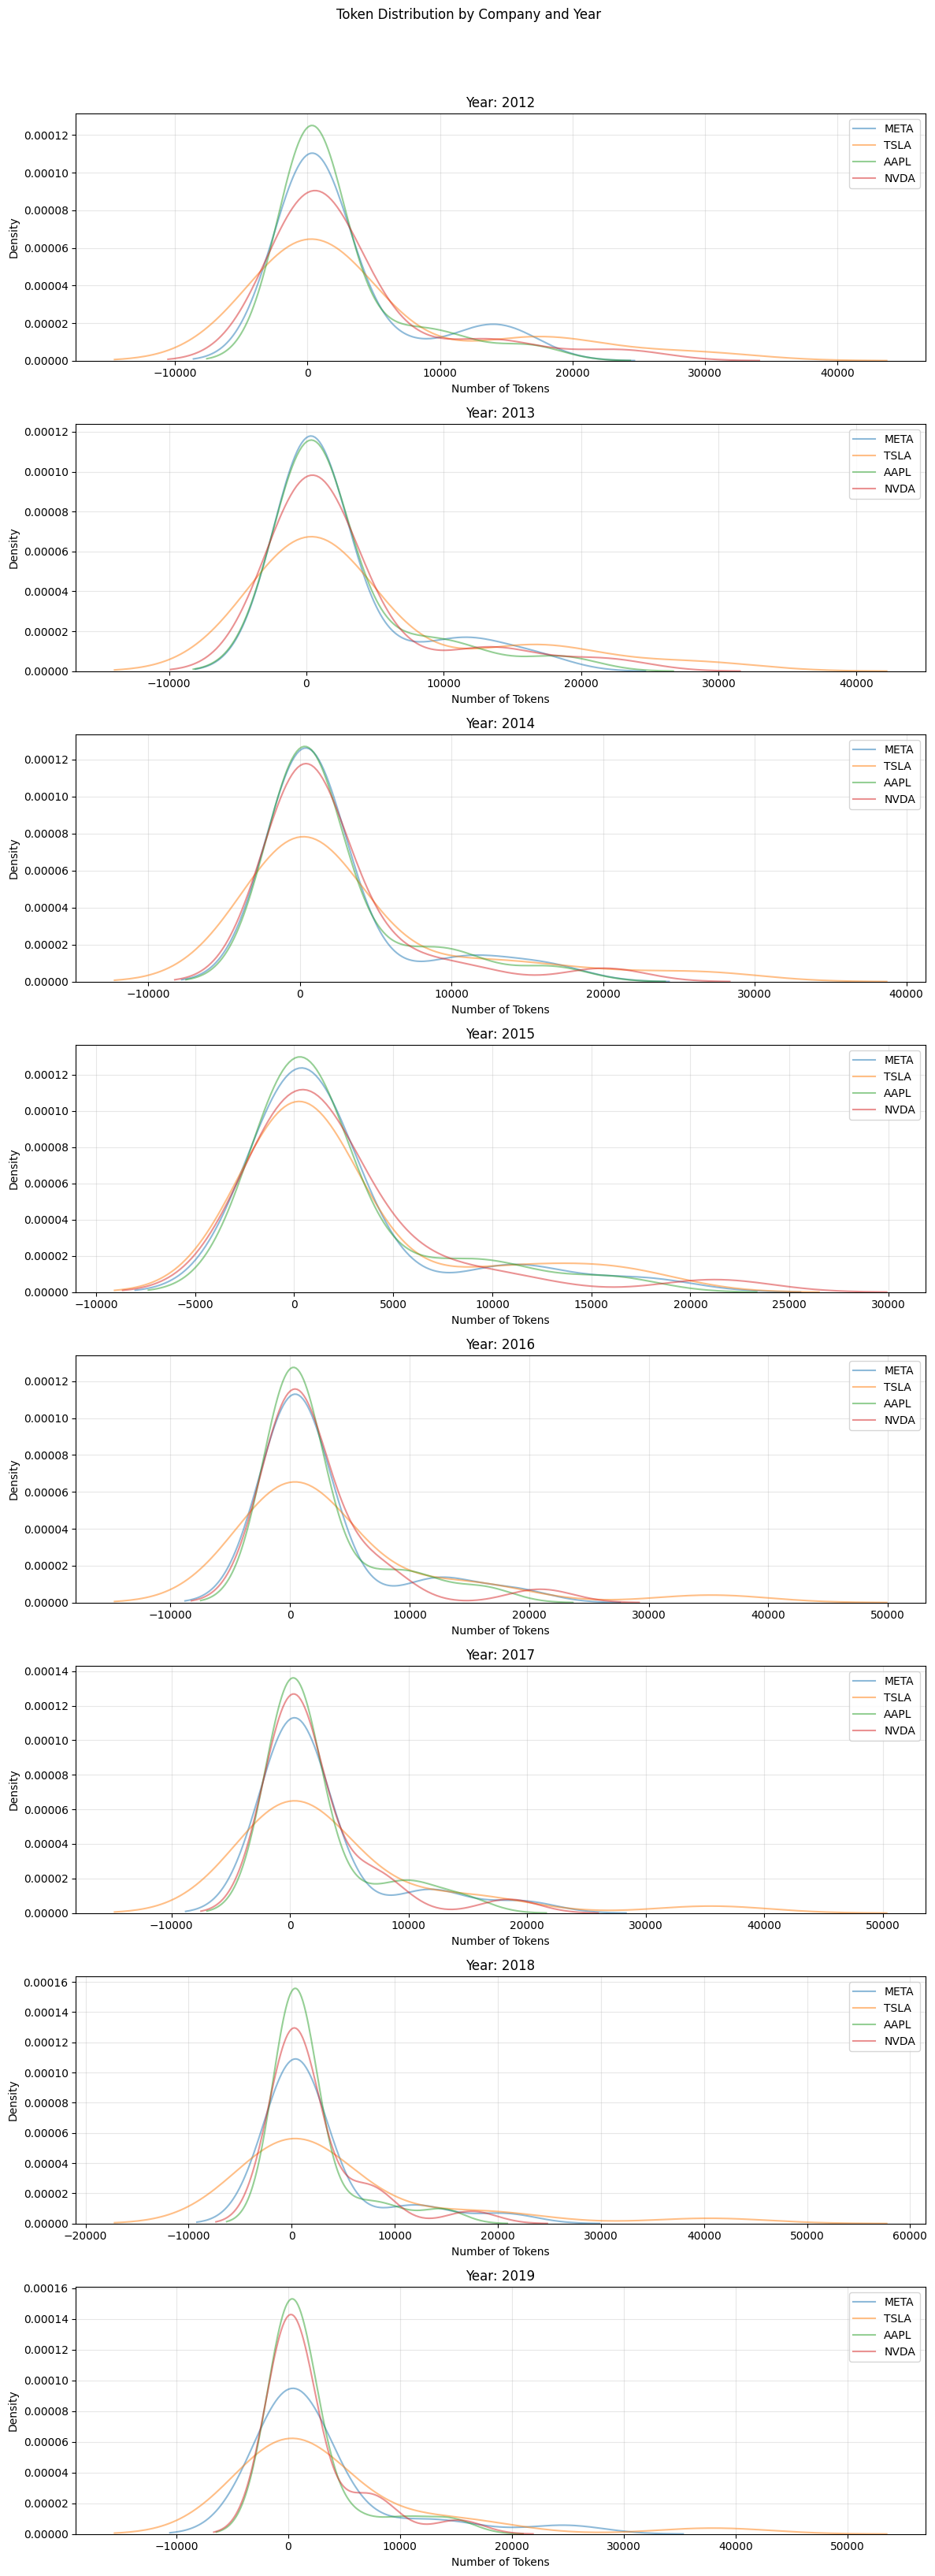

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

years = sorted(df_filings_exploded['fiscal_year'].unique())

# Create subplots for each year
fig, axes = plt.subplots(len(years), 1, figsize=(12, 4*len(years)))
fig.suptitle('Token Distribution by Company and Year', y=1.02)

# Plot distribution for each year
for idx, year in enumerate(years):
    year_data = df_filings_exploded[df_filings_exploded['fiscal_year'] == year]
    
    # Plot distribution for each company in this year
    for ticker in year_data['ticker'].unique():
        data = year_data[year_data['ticker'] == ticker]['tokens']
        sns.kdeplot(data=data, label=ticker, alpha=0.5, ax=axes[idx])
    
    axes[idx].set_title(f'Year: {year}')
    axes[idx].set_xlabel('Number of Tokens')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Distributions are off. Looks like TSLA tends to have much longer SEC filings, while AAPL has quite short ones. 

In [3]:
df_filings_exploded['ticker'].value_counts()

ticker
META    160
AAPL    160
NVDA    160
TSLA    158
Name: count, dtype: int64

The number of sections is still evenly distributed. What about the distribution of the sections available in each report?

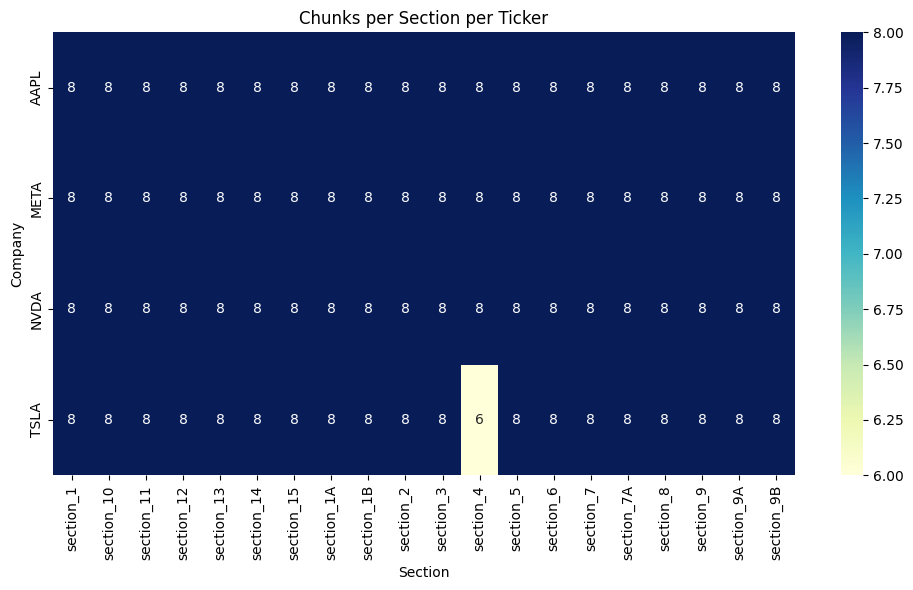

In [4]:
section_balance = (
    df_filings_exploded
    .groupby(["ticker", "section"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)


plt.figure(figsize=(10, 6))
sns.heatmap(section_balance, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Chunks per Section per Ticker")
plt.ylabel("Company")
plt.xlabel("Section")
plt.tight_layout()
plt.show()


So they all have the same amount of sections, except TSLA in section 4. Let's compare the number of tokens per section. 

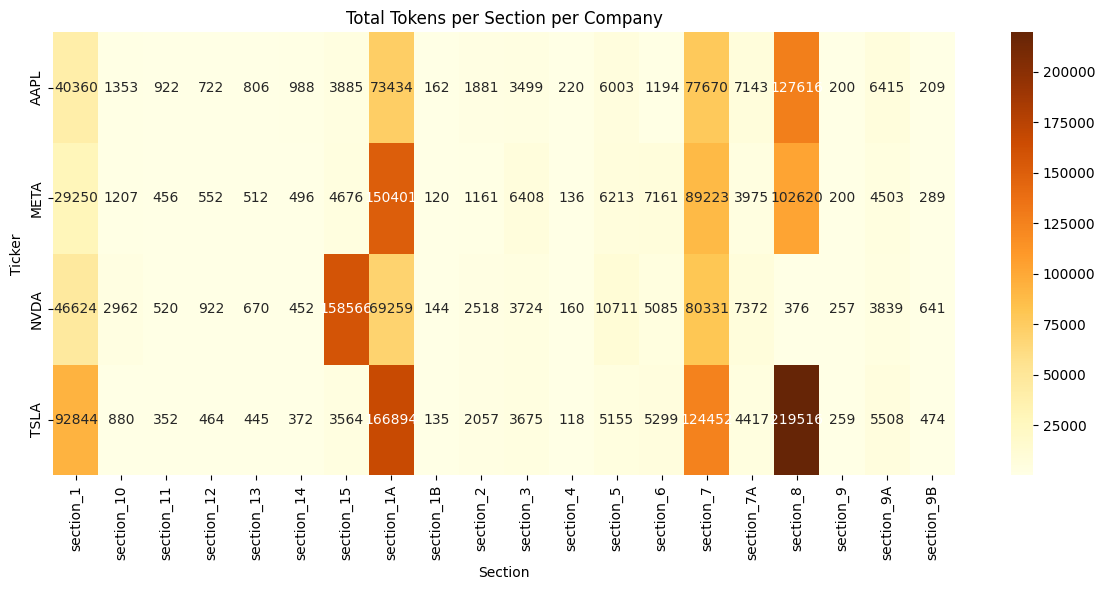

In [5]:
token_matrix = (
    df_filings_exploded
    .groupby(["ticker", "section"])["tokens"]
    .sum()
    .unstack(fill_value=0)
)
plt.figure(figsize=(12, 6))
sns.heatmap(token_matrix, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Total Tokens per Section per Company")
plt.xlabel("Section")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()


Looks like there's some class imbalance we should normalize against. TSLA consistently has longer SEC filings, but are the chunks consistently approaching our hard upper limit of 850 tokens? Let's see how chunks per company are greater than 500 tokens. 

In [6]:

# Assume `chunks` is your list of Chunk objects
chunk_records = []
for idx, c in enumerate(chunks):
    token_count = len(tokenizer.encode(c.text))
    chunk_records.append({
        "idx": idx,
        "ticker": c.metadata["ticker"],
        "year": c.metadata["fiscal_year"],
        "section": c.metadata["item"],
        "token_count": token_count
    })

df_chunks = pd.DataFrame(chunk_records)
df_chunks.head()

,idx,ticker,year,section,token_count
0,0,META,2019,1,330
1,1,META,2019,1,339
2,2,META,2019,1,337
3,3,META,2019,1,345
4,4,META,2019,1,347


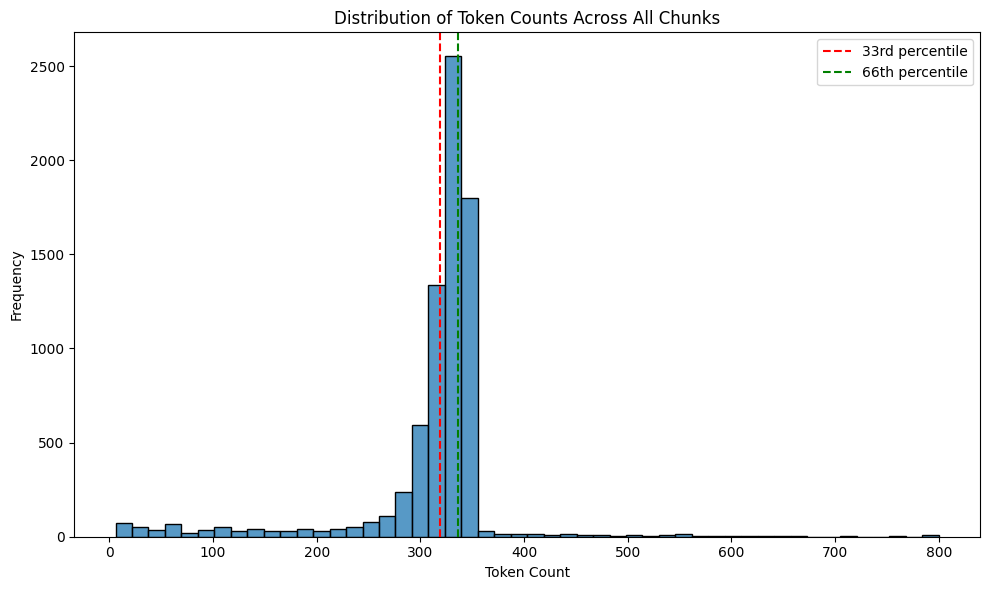

33rd percentile: 319 tokens
66th percentile: 336 tokens


In [7]:
# Plot histogram of token counts to analyze distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_chunks, x="token_count", bins=50)
plt.axvline(x=df_chunks["token_count"].quantile(0.33), color='r', linestyle='--', label='33rd percentile')
plt.axvline(x=df_chunks["token_count"].quantile(0.66), color='g', linestyle='--', label='66th percentile')
plt.title("Distribution of Token Counts Across All Chunks")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Print percentile values for reference
p33 = df_chunks["token_count"].quantile(0.33)
p66 = df_chunks["token_count"].quantile(0.66)
print(f"33rd percentile: {p33:.0f} tokens")
print(f"66th percentile: {p66:.0f} tokens")


So from what we see here, we can group the chunks into three sizes:
- Small: 0-300
- Medium: 300-375
- Large: >375

Are there some companies that have more representation in large chunks than others?

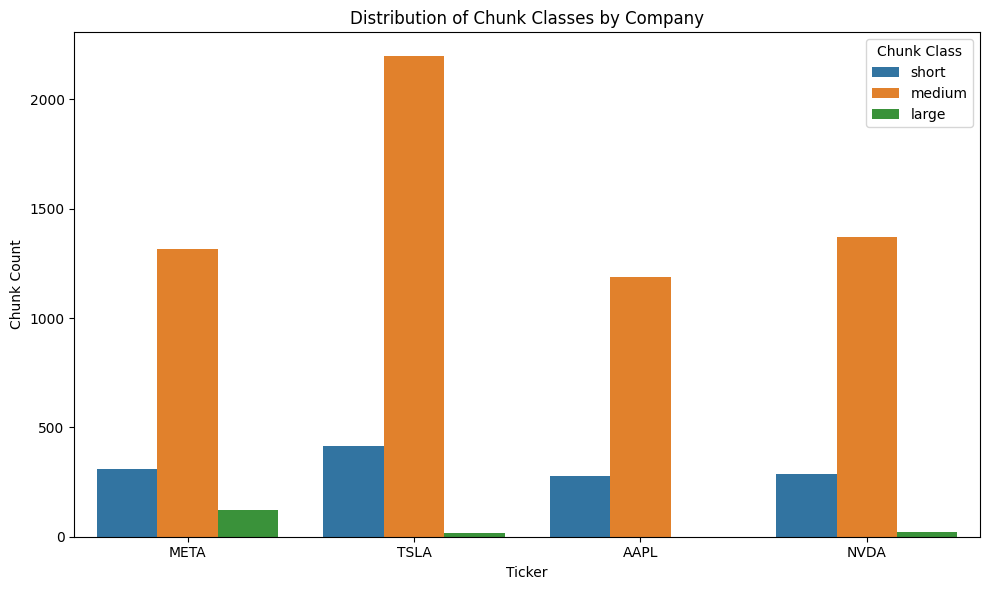

In [8]:
# Create new classification based on percentiles
df_chunks["chunk_class"] = pd.cut(
    df_chunks["token_count"],
    bins=[0, 300, 375, float("inf")],
    labels=["short", "medium", "large"]
)

# Plot distribution of chunk classes by company
plt.figure(figsize=(10, 6))
sns.countplot(data=df_chunks, x="ticker", hue="chunk_class")
plt.title("Distribution of Chunk Classes by Company")
plt.ylabel("Chunk Count")
plt.xlabel("Ticker")
plt.legend(title="Chunk Class")
plt.tight_layout()
plt.show()

Meta has significantly more large chunks than any of the other companies. We should mitigate this balance. 

Alright so this is what we see about the dataset:
- Sections are more or less equally represented amongst the companies. 
- Lengths of sections are not necessarily equally represented (e.g. NVDA has section 15s that are much longer than the other companies)
- META in general has many more long chunks than NVDA or TSLA. 

In order to make sure our evaluation set is unbiased, we'll do the following:
- **Stratify sampling across key dimensions**. We'll ensure balanced representation across company, year, section, and chunk class (short, medium, extra_large).
- **Downsample overrepresented long chunks**. Each company will contribute an equal number of long chunks to prevent verbosity from dominating QA coverage.
- **Limit QA pairs per group**. Each `(company, year, section, chunk_class)` group will be capped to a consistent number of QA pairs to enforce balance.



## Generate representative QA labeled dataset

In [12]:
%load_ext autoreload
%autoreload 2

import pickle, json
from pathlib import Path
from evaluation.normalize_qa_sample import BalancedChunkSampler, generate_qa_pairs, classify_chunk_by_tokens
from collections import Counter

# Load chunks
try:
    with open(data_dir / "chunks.pkl", "rb") as f:
        chunks = pickle.load(f)
    print(f"📊 Loaded {len(chunks)} chunks")
except FileNotFoundError:
    print("❌ chunks.pkl not found. Make sure the file exists.")
    exit(1)

# Create balanced sample
sampler = BalancedChunkSampler(max_per_group=5, balance_companies=True)
grouped = sampler.group_chunks_by_keys(chunks)
balanced_chunks = sampler.stratified_sample(grouped)

print(f"📊 Balanced sample: {len(balanced_chunks)} chunks from {len(grouped)} groups")

# Show final distribution
company_dist = Counter(chunk.metadata["ticker"] for chunk in balanced_chunks)
chunk_class_dist = Counter(classify_chunk_by_tokens(chunk.text) for chunk in balanced_chunks)

print(f"📈 Final distribution:")
print(f"   By company: {dict(company_dist)}")
print(f"   By chunk class: {dict(chunk_class_dist)}")

# Save balanced chunks

save_path = data_dir / "balanced_chunks_for_eval.jsonl"
sampler.save_chunks_to_jsonl(balanced_chunks, save_path)
print(f"✅ Saved balanced chunks to {save_path}")

# Check if QA dataset exists, load it if it does, otherwise generate it
qa_output_path = data_dir / "qa_dataset.jsonl"
if qa_output_path.exists():
    print(f"✅ Found existing QA dataset at {qa_output_path}")
    with open(qa_output_path, 'r') as f:
        qa_ds = [json.loads(line) for line in f]
else:
    print("🔄 Generating new QA pairs...")
    generate_qa_pairs(balanced_chunks, str(qa_output_path))
    with open(qa_output_path, 'r') as f:
        qa_ds = [json.loads(line) for line in f]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
📊 Loaded 7523 chunks
🎯 Balancing to 365 chunks per company
   META: 365 chunks
   TSLA: 365 chunks
   AAPL: 365 chunks
   NVDA: 365 chunks
📊 Balanced sample: 1460 chunks from 684 groups
📈 Final distribution:
   By company: {'META': 365, 'TSLA': 365, 'AAPL': 365, 'NVDA': 365}
   By chunk class: {'short': 1348, 'extra_large': 39, 'medium': 73}
✅ Saved balanced chunks to /Users/jon/GitHub/dowjones-takehome/data/balanced_chunks_for_eval.jsonl
🔄 Generating new QA pairs...


🤖 Generating QA pairs:   1%|          | 10/1460 [00:18<38:23,  1.59s/chunk] , Company=META, Year=2019, Success=10/11, QA_pairs=20

✅ Processed 10 chunks, generated 20 QA pairs


🤖 Generating QA pairs:   1%|▏         | 20/1460 [00:38<47:43,  1.99s/chunk] , Company=META, Year=2018, Success=20/21, QA_pairs=40

✅ Processed 20 chunks, generated 40 QA pairs


🤖 Generating QA pairs:   2%|▏         | 30/1460 [00:56<36:18,  1.52s/chunk] , Company=META, Year=2019, Success=30/31, QA_pairs=58

✅ Processed 30 chunks, generated 58 QA pairs


🤖 Generating QA pairs:   3%|▎         | 40/1460 [01:14<42:58,  1.82s/chunk] , Company=META, Year=2016, Success=40/41, QA_pairs=78

✅ Processed 40 chunks, generated 78 QA pairs


🤖 Generating QA pairs:   3%|▎         | 50/1460 [01:34<53:29,  2.28s/chunk] , Company=META, Year=2016, Success=50/51, QA_pairs=98

✅ Processed 50 chunks, generated 98 QA pairs


🤖 Generating QA pairs:   4%|▍         | 60/1460 [01:51<40:19,  1.73s/chunk] , Company=META, Year=2014, Success=60/61, QA_pairs=118

✅ Processed 60 chunks, generated 118 QA pairs


🤖 Generating QA pairs:   5%|▍         | 70/1460 [02:10<41:33,  1.79s/chunk] , Company=META, Year=2018, Success=70/71, QA_pairs=138

✅ Processed 70 chunks, generated 138 QA pairs


🤖 Generating QA pairs:   5%|▌         | 80/1460 [02:28<44:14,  1.92s/chunk] , Company=META, Year=2014, Success=80/81, QA_pairs=158

✅ Processed 80 chunks, generated 158 QA pairs


🤖 Generating QA pairs:   6%|▌         | 90/1460 [02:46<42:25,  1.86s/chunk] , Company=META, Year=2016, Success=90/91, QA_pairs=178

✅ Processed 90 chunks, generated 178 QA pairs


🤖 Generating QA pairs:   7%|▋         | 100/1460 [03:04<40:12,  1.77s/chunk] , Company=META, Year=2019, Success=100/101, QA_pairs=198

✅ Processed 100 chunks, generated 198 QA pairs


🤖 Generating QA pairs:   8%|▊         | 110/1460 [03:24<43:28,  1.93s/chunk] , Company=META, Year=2012, Success=110/111, QA_pairs=218

✅ Processed 110 chunks, generated 218 QA pairs


🤖 Generating QA pairs:   8%|▊         | 120/1460 [03:42<30:19,  1.36s/chunk] , Company=META, Year=2018, Success=120/121, QA_pairs=236

✅ Processed 120 chunks, generated 236 QA pairs


🤖 Generating QA pairs:   9%|▉         | 130/1460 [04:01<42:28,  1.92s/chunk] , Company=META, Year=2015, Success=130/131, QA_pairs=256

✅ Processed 130 chunks, generated 256 QA pairs


🤖 Generating QA pairs:  10%|▉         | 140/1460 [04:19<40:35,  1.84s/chunk] , Company=META, Year=2016, Success=140/141, QA_pairs=276

✅ Processed 140 chunks, generated 276 QA pairs


🤖 Generating QA pairs:  10%|█         | 150/1460 [04:37<41:50,  1.92s/chunk] , Company=META, Year=2016, Success=150/151, QA_pairs=296

✅ Processed 150 chunks, generated 296 QA pairs


🤖 Generating QA pairs:  11%|█         | 160/1460 [04:54<35:44,  1.65s/chunk] , Company=META, Year=2019, Success=160/161, QA_pairs=316

✅ Processed 160 chunks, generated 316 QA pairs


🤖 Generating QA pairs:  12%|█▏        | 170/1460 [05:12<35:45,  1.66s/chunk] , Company=META, Year=2018, Success=170/171, QA_pairs=333

✅ Processed 170 chunks, generated 333 QA pairs


🤖 Generating QA pairs:  12%|█▏        | 180/1460 [05:31<39:37,  1.86s/chunk] , Company=META, Year=2013, Success=180/181, QA_pairs=353

✅ Processed 180 chunks, generated 353 QA pairs


🤖 Generating QA pairs:  13%|█▎        | 190/1460 [05:54<1:00:09,  2.84s/chunk] , Company=META, Year=2016, Success=190/191, QA_pairs=373

✅ Processed 190 chunks, generated 373 QA pairs


🤖 Generating QA pairs:  14%|█▎        | 200/1460 [06:14<40:23,  1.92s/chunk] , Company=META, Year=2015, Success=200/201, QA_pairs=393  

✅ Processed 200 chunks, generated 393 QA pairs


🤖 Generating QA pairs:  14%|█▍        | 210/1460 [06:31<37:40,  1.81s/chunk] , Company=META, Year=2012, Success=210/211, QA_pairs=411

✅ Processed 210 chunks, generated 411 QA pairs


🤖 Generating QA pairs:  15%|█▌        | 220/1460 [06:50<41:09,  1.99s/chunk] , Company=META, Year=2015, Success=220/221, QA_pairs=431

✅ Processed 220 chunks, generated 431 QA pairs


🤖 Generating QA pairs:  16%|█▌        | 230/1460 [07:10<42:25,  2.07s/chunk] , Company=META, Year=2012, Success=230/231, QA_pairs=451

✅ Processed 230 chunks, generated 451 QA pairs


🤖 Generating QA pairs:  16%|█▋        | 240/1460 [07:32<45:09,  2.22s/chunk] , Company=META, Year=2012, Success=240/241, QA_pairs=471

✅ Processed 240 chunks, generated 471 QA pairs


🤖 Generating QA pairs:  17%|█▋        | 250/1460 [07:51<32:52,  1.63s/chunk] , Company=META, Year=2015, Success=250/251, QA_pairs=491

✅ Processed 250 chunks, generated 491 QA pairs


🤖 Generating QA pairs:  18%|█▊        | 260/1460 [08:08<38:18,  1.92s/chunk] , Company=META, Year=2012, Success=260/261, QA_pairs=509

✅ Processed 260 chunks, generated 509 QA pairs


🤖 Generating QA pairs:  18%|█▊        | 270/1460 [08:27<36:20,  1.83s/chunk] , Company=META, Year=2014, Success=270/271, QA_pairs=529

✅ Processed 270 chunks, generated 529 QA pairs


🤖 Generating QA pairs:  19%|█▉        | 280/1460 [08:45<36:01,  1.83s/chunk] , Company=META, Year=2018, Success=280/281, QA_pairs=549

✅ Processed 280 chunks, generated 549 QA pairs


🤖 Generating QA pairs:  20%|█▉        | 290/1460 [09:06<38:52,  1.99s/chunk] , Company=META, Year=2016, Success=290/291, QA_pairs=569

✅ Processed 290 chunks, generated 569 QA pairs


🤖 Generating QA pairs:  21%|██        | 300/1460 [09:23<34:40,  1.79s/chunk] , Company=META, Year=2015, Success=300/301, QA_pairs=589

✅ Processed 300 chunks, generated 589 QA pairs


🤖 Generating QA pairs:  21%|██        | 310/1460 [09:43<38:15,  2.00s/chunk] , Company=META, Year=2014, Success=310/311, QA_pairs=609

✅ Processed 310 chunks, generated 609 QA pairs


🤖 Generating QA pairs:  22%|██▏       | 320/1460 [10:03<39:32,  2.08s/chunk] , Company=META, Year=2012, Success=320/321, QA_pairs=629

✅ Processed 320 chunks, generated 629 QA pairs


🤖 Generating QA pairs:  23%|██▎       | 330/1460 [10:21<34:25,  1.83s/chunk] , Company=META, Year=2012, Success=330/331, QA_pairs=647

✅ Processed 330 chunks, generated 647 QA pairs


🤖 Generating QA pairs:  23%|██▎       | 340/1460 [10:37<32:45,  1.76s/chunk] , Company=META, Year=2014, Success=340/341, QA_pairs=666

✅ Processed 340 chunks, generated 666 QA pairs


🤖 Generating QA pairs:  24%|██▍       | 350/1460 [10:56<27:43,  1.50s/chunk] , Company=META, Year=2018, Success=350/351, QA_pairs=684

✅ Processed 350 chunks, generated 684 QA pairs


🤖 Generating QA pairs:  25%|██▍       | 360/1460 [11:17<30:58,  1.69s/chunk] , Company=META, Year=2018, Success=360/361, QA_pairs=704

✅ Processed 360 chunks, generated 704 QA pairs


🤖 Generating QA pairs:  25%|██▌       | 370/1460 [11:35<35:51,  1.97s/chunk] , Company=TSLA, Year=2013, Success=370/371, QA_pairs=722

✅ Processed 370 chunks, generated 722 QA pairs


🤖 Generating QA pairs:  26%|██▌       | 380/1460 [11:57<40:13,  2.24s/chunk] , Company=TSLA, Year=2015, Success=380/381, QA_pairs=742

✅ Processed 380 chunks, generated 742 QA pairs


🤖 Generating QA pairs:  27%|██▋       | 390/1460 [12:15<33:46,  1.89s/chunk] , Company=TSLA, Year=2012, Success=390/391, QA_pairs=762

✅ Processed 390 chunks, generated 762 QA pairs


🤖 Generating QA pairs:  27%|██▋       | 400/1460 [12:33<31:20,  1.77s/chunk] , Company=TSLA, Year=2017, Success=400/401, QA_pairs=781

✅ Processed 400 chunks, generated 781 QA pairs


🤖 Generating QA pairs:  28%|██▊       | 410/1460 [12:51<30:55,  1.77s/chunk] , Company=TSLA, Year=2017, Success=410/411, QA_pairs=801

✅ Processed 410 chunks, generated 801 QA pairs


🤖 Generating QA pairs:  29%|██▉       | 420/1460 [13:08<29:20,  1.69s/chunk] , Company=TSLA, Year=2015, Success=420/421, QA_pairs=821

✅ Processed 420 chunks, generated 821 QA pairs


🤖 Generating QA pairs:  29%|██▉       | 430/1460 [13:25<30:00,  1.75s/chunk] , Company=TSLA, Year=2019, Success=430/431, QA_pairs=841

✅ Processed 430 chunks, generated 841 QA pairs


🤖 Generating QA pairs:  30%|███       | 440/1460 [13:45<32:24,  1.91s/chunk] , Company=TSLA, Year=2017, Success=440/441, QA_pairs=861

✅ Processed 440 chunks, generated 861 QA pairs


🤖 Generating QA pairs:  31%|███       | 450/1460 [14:03<31:27,  1.87s/chunk] , Company=TSLA, Year=2019, Success=450/451, QA_pairs=881

✅ Processed 450 chunks, generated 881 QA pairs


🤖 Generating QA pairs:  32%|███▏      | 460/1460 [14:20<28:34,  1.71s/chunk] , Company=TSLA, Year=2019, Success=460/461, QA_pairs=901

✅ Processed 460 chunks, generated 901 QA pairs


🤖 Generating QA pairs:  32%|███▏      | 470/1460 [14:37<26:39,  1.62s/chunk] , Company=TSLA, Year=2016, Success=470/471, QA_pairs=921

✅ Processed 470 chunks, generated 921 QA pairs


🤖 Generating QA pairs:  33%|███▎      | 480/1460 [14:57<30:27,  1.87s/chunk] , Company=TSLA, Year=2018, Success=480/481, QA_pairs=941

✅ Processed 480 chunks, generated 941 QA pairs


🤖 Generating QA pairs:  34%|███▎      | 490/1460 [15:15<27:50,  1.72s/chunk] , Company=TSLA, Year=2016, Success=490/491, QA_pairs=961

✅ Processed 490 chunks, generated 961 QA pairs


🤖 Generating QA pairs:  34%|███▍      | 500/1460 [15:33<30:16,  1.89s/chunk] , Company=TSLA, Year=2013, Success=500/501, QA_pairs=981

✅ Processed 500 chunks, generated 981 QA pairs


🤖 Generating QA pairs:  35%|███▍      | 510/1460 [15:49<22:28,  1.42s/chunk] , Company=TSLA, Year=2016, Success=510/511, QA_pairs=999

✅ Processed 510 chunks, generated 999 QA pairs


🤖 Generating QA pairs:  36%|███▌      | 520/1460 [16:09<28:12,  1.80s/chunk] , Company=TSLA, Year=2016, Success=520/521, QA_pairs=1019

✅ Processed 520 chunks, generated 1019 QA pairs


🤖 Generating QA pairs:  36%|███▋      | 530/1460 [16:28<28:45,  1.86s/chunk] , Company=TSLA, Year=2013, Success=530/531, QA_pairs=1039

✅ Processed 530 chunks, generated 1039 QA pairs


🤖 Generating QA pairs:  37%|███▋      | 540/1460 [16:45<22:12,  1.45s/chunk] , Company=TSLA, Year=2017, Success=540/541, QA_pairs=1059

✅ Processed 540 chunks, generated 1059 QA pairs


🤖 Generating QA pairs:  38%|███▊      | 550/1460 [17:02<24:50,  1.64s/chunk] , Company=TSLA, Year=2014, Success=550/551, QA_pairs=1079

✅ Processed 550 chunks, generated 1079 QA pairs


🤖 Generating QA pairs:  38%|███▊      | 560/1460 [17:19<23:49,  1.59s/chunk] , Company=TSLA, Year=2015, Success=560/561, QA_pairs=1099

✅ Processed 560 chunks, generated 1099 QA pairs


🤖 Generating QA pairs:  39%|███▉      | 570/1460 [17:37<26:09,  1.76s/chunk] , Company=TSLA, Year=2019, Success=570/571, QA_pairs=1119

✅ Processed 570 chunks, generated 1119 QA pairs


🤖 Generating QA pairs:  40%|███▉      | 580/1460 [18:00<33:30,  2.29s/chunk] , Company=TSLA, Year=2017, Success=580/581, QA_pairs=1139

✅ Processed 580 chunks, generated 1139 QA pairs


🤖 Generating QA pairs:  40%|████      | 590/1460 [18:18<26:02,  1.80s/chunk] , Company=TSLA, Year=2013, Success=590/591, QA_pairs=1157

✅ Processed 590 chunks, generated 1157 QA pairs


🤖 Generating QA pairs:  41%|████      | 600/1460 [18:36<25:27,  1.78s/chunk] , Company=TSLA, Year=2016, Success=600/601, QA_pairs=1177

✅ Processed 600 chunks, generated 1177 QA pairs


🤖 Generating QA pairs:  42%|████▏     | 610/1460 [18:55<24:56,  1.76s/chunk] , Company=TSLA, Year=2012, Success=610/611, QA_pairs=1196

✅ Processed 610 chunks, generated 1196 QA pairs


🤖 Generating QA pairs:  42%|████▏     | 620/1460 [19:11<21:52,  1.56s/chunk] , Company=TSLA, Year=2012, Success=620/621, QA_pairs=1216

✅ Processed 620 chunks, generated 1216 QA pairs


🤖 Generating QA pairs:  43%|████▎     | 630/1460 [19:27<20:54,  1.51s/chunk] , Company=TSLA, Year=2017, Success=630/631, QA_pairs=1234

✅ Processed 630 chunks, generated 1234 QA pairs


🤖 Generating QA pairs:  44%|████▍     | 640/1460 [19:45<25:11,  1.84s/chunk] , Company=TSLA, Year=2013, Success=640/641, QA_pairs=1254

✅ Processed 640 chunks, generated 1254 QA pairs


🤖 Generating QA pairs:  45%|████▍     | 650/1460 [20:04<28:19,  2.10s/chunk] , Company=TSLA, Year=2015, Success=650/651, QA_pairs=1274

✅ Processed 650 chunks, generated 1274 QA pairs


🤖 Generating QA pairs:  45%|████▌     | 660/1460 [20:24<27:29,  2.06s/chunk] , Company=TSLA, Year=2018, Success=660/661, QA_pairs=1294

✅ Processed 660 chunks, generated 1294 QA pairs


🤖 Generating QA pairs:  46%|████▌     | 670/1460 [20:42<21:51,  1.66s/chunk] , Company=TSLA, Year=2019, Success=670/671, QA_pairs=1313

✅ Processed 670 chunks, generated 1313 QA pairs


🤖 Generating QA pairs:  47%|████▋     | 680/1460 [20:59<26:19,  2.02s/chunk] , Company=TSLA, Year=2016, Success=680/681, QA_pairs=1331

✅ Processed 680 chunks, generated 1331 QA pairs


🤖 Generating QA pairs:  47%|████▋     | 690/1460 [21:18<24:28,  1.91s/chunk] , Company=TSLA, Year=2016, Success=690/691, QA_pairs=1351

✅ Processed 690 chunks, generated 1351 QA pairs


🤖 Generating QA pairs:  48%|████▊     | 700/1460 [21:35<20:04,  1.59s/chunk] , Company=TSLA, Year=2019, Success=700/701, QA_pairs=1371

✅ Processed 700 chunks, generated 1371 QA pairs


🤖 Generating QA pairs:  49%|████▊     | 710/1460 [21:53<22:26,  1.79s/chunk] , Company=TSLA, Year=2015, Success=710/711, QA_pairs=1391

✅ Processed 710 chunks, generated 1391 QA pairs


🤖 Generating QA pairs:  49%|████▉     | 720/1460 [22:14<22:42,  1.84s/chunk] , Company=TSLA, Year=2018, Success=720/721, QA_pairs=1411

✅ Processed 720 chunks, generated 1411 QA pairs


🤖 Generating QA pairs:  50%|█████     | 730/1460 [22:32<21:51,  1.80s/chunk] , Company=AAPL, Year=2019, Success=730/731, QA_pairs=1431

✅ Processed 730 chunks, generated 1431 QA pairs


🤖 Generating QA pairs:  51%|█████     | 740/1460 [22:50<22:17,  1.86s/chunk] , Company=AAPL, Year=2019, Success=740/741, QA_pairs=1451

✅ Processed 740 chunks, generated 1451 QA pairs


🤖 Generating QA pairs:  51%|█████▏    | 750/1460 [23:11<23:39,  2.00s/chunk] , Company=AAPL, Year=2019, Success=750/751, QA_pairs=1471

✅ Processed 750 chunks, generated 1471 QA pairs


🤖 Generating QA pairs:  52%|█████▏    | 760/1460 [23:31<25:52,  2.22s/chunk] , Company=AAPL, Year=2019, Success=760/761, QA_pairs=1491

✅ Processed 760 chunks, generated 1491 QA pairs


🤖 Generating QA pairs:  53%|█████▎    | 770/1460 [23:52<24:19,  2.12s/chunk] , Company=AAPL, Year=2019, Success=770/771, QA_pairs=1511

✅ Processed 770 chunks, generated 1511 QA pairs


🤖 Generating QA pairs:  53%|█████▎    | 780/1460 [24:10<20:49,  1.84s/chunk] , Company=AAPL, Year=2018, Success=780/781, QA_pairs=1531

✅ Processed 780 chunks, generated 1531 QA pairs


🤖 Generating QA pairs:  54%|█████▍    | 790/1460 [24:31<23:01,  2.06s/chunk] , Company=AAPL, Year=2018, Success=790/791, QA_pairs=1551

✅ Processed 790 chunks, generated 1551 QA pairs


🤖 Generating QA pairs:  55%|█████▍    | 800/1460 [24:49<20:05,  1.83s/chunk] , Company=AAPL, Year=2018, Success=800/801, QA_pairs=1571

✅ Processed 800 chunks, generated 1571 QA pairs


🤖 Generating QA pairs:  55%|█████▌    | 810/1460 [25:10<21:44,  2.01s/chunk] , Company=AAPL, Year=2018, Success=810/811, QA_pairs=1591

✅ Processed 810 chunks, generated 1591 QA pairs


🤖 Generating QA pairs:  56%|█████▌    | 820/1460 [25:27<19:19,  1.81s/chunk] , Company=AAPL, Year=2017, Success=820/821, QA_pairs=1611

✅ Processed 820 chunks, generated 1611 QA pairs


🤖 Generating QA pairs:  57%|█████▋    | 830/1460 [25:45<19:16,  1.84s/chunk] , Company=AAPL, Year=2017, Success=830/831, QA_pairs=1631

✅ Processed 830 chunks, generated 1631 QA pairs


🤖 Generating QA pairs:  58%|█████▊    | 840/1460 [26:05<20:22,  1.97s/chunk] , Company=AAPL, Year=2017, Success=840/841, QA_pairs=1651

✅ Processed 840 chunks, generated 1651 QA pairs


🤖 Generating QA pairs:  58%|█████▊    | 850/1460 [26:24<20:03,  1.97s/chunk] , Company=AAPL, Year=2017, Success=850/851, QA_pairs=1671

✅ Processed 850 chunks, generated 1671 QA pairs


🤖 Generating QA pairs:  59%|█████▉    | 860/1460 [26:44<19:15,  1.93s/chunk] , Company=AAPL, Year=2017, Success=860/861, QA_pairs=1691

✅ Processed 860 chunks, generated 1691 QA pairs


🤖 Generating QA pairs:  60%|█████▉    | 870/1460 [27:02<19:19,  1.97s/chunk] , Company=AAPL, Year=2016, Success=870/871, QA_pairs=1711

✅ Processed 870 chunks, generated 1711 QA pairs


🤖 Generating QA pairs:  60%|██████    | 880/1460 [27:20<16:53,  1.75s/chunk] , Company=AAPL, Year=2016, Success=880/881, QA_pairs=1731

✅ Processed 880 chunks, generated 1731 QA pairs


🤖 Generating QA pairs:  61%|██████    | 890/1460 [27:39<20:23,  2.15s/chunk] , Company=AAPL, Year=2016, Success=890/891, QA_pairs=1751

✅ Processed 890 chunks, generated 1751 QA pairs


🤖 Generating QA pairs:  62%|██████▏   | 900/1460 [27:59<21:30,  2.30s/chunk] , Company=AAPL, Year=2016, Success=900/901, QA_pairs=1771

✅ Processed 900 chunks, generated 1771 QA pairs


🤖 Generating QA pairs:  62%|██████▏   | 910/1460 [28:20<18:50,  2.06s/chunk] , Company=AAPL, Year=2015, Success=910/911, QA_pairs=1791

✅ Processed 910 chunks, generated 1791 QA pairs


🤖 Generating QA pairs:  63%|██████▎   | 920/1460 [28:41<17:23,  1.93s/chunk] , Company=AAPL, Year=2015, Success=920/921, QA_pairs=1811

✅ Processed 920 chunks, generated 1811 QA pairs


🤖 Generating QA pairs:  64%|██████▎   | 930/1460 [29:01<17:42,  2.00s/chunk] , Company=AAPL, Year=2015, Success=930/931, QA_pairs=1831

✅ Processed 930 chunks, generated 1831 QA pairs


🤖 Generating QA pairs:  64%|██████▍   | 940/1460 [29:22<16:21,  1.89s/chunk] , Company=AAPL, Year=2015, Success=940/941, QA_pairs=1851

✅ Processed 940 chunks, generated 1851 QA pairs


🤖 Generating QA pairs:  65%|██████▌   | 950/1460 [29:42<16:26,  1.94s/chunk] , Company=AAPL, Year=2015, Success=950/951, QA_pairs=1871

✅ Processed 950 chunks, generated 1871 QA pairs


🤖 Generating QA pairs:  66%|██████▌   | 960/1460 [30:00<15:26,  1.85s/chunk] , Company=AAPL, Year=2014, Success=960/961, QA_pairs=1891

✅ Processed 960 chunks, generated 1891 QA pairs


🤖 Generating QA pairs:  66%|██████▋   | 970/1460 [30:18<13:51,  1.70s/chunk] , Company=AAPL, Year=2014, Success=970/971, QA_pairs=1911

✅ Processed 970 chunks, generated 1911 QA pairs


🤖 Generating QA pairs:  67%|██████▋   | 980/1460 [30:40<17:34,  2.20s/chunk] , Company=AAPL, Year=2014, Success=980/981, QA_pairs=1931

✅ Processed 980 chunks, generated 1931 QA pairs


🤖 Generating QA pairs:  68%|██████▊   | 990/1460 [31:00<15:36,  1.99s/chunk] , Company=AAPL, Year=2014, Success=990/991, QA_pairs=1951

✅ Processed 990 chunks, generated 1951 QA pairs


🤖 Generating QA pairs:  68%|██████▊   | 1000/1460 [31:20<15:00,  1.96s/chunk] , Company=AAPL, Year=2013, Success=1000/1001, QA_pairs=1971

✅ Processed 1000 chunks, generated 1971 QA pairs


🤖 Generating QA pairs:  69%|██████▉   | 1010/1460 [31:40<14:00,  1.87s/chunk] , Company=AAPL, Year=2013, Success=1010/1011, QA_pairs=1991

✅ Processed 1010 chunks, generated 1991 QA pairs


🤖 Generating QA pairs:  70%|██████▉   | 1020/1460 [31:58<13:29,  1.84s/chunk] , Company=AAPL, Year=2013, Success=1020/1021, QA_pairs=2011

✅ Processed 1020 chunks, generated 2011 QA pairs


🤖 Generating QA pairs:  71%|███████   | 1030/1460 [32:20<15:57,  2.23s/chunk] , Company=AAPL, Year=2013, Success=1030/1031, QA_pairs=2031

✅ Processed 1030 chunks, generated 2031 QA pairs


🤖 Generating QA pairs:  71%|███████   | 1040/1460 [32:41<16:08,  2.31s/chunk] , Company=AAPL, Year=2013, Success=1040/1041, QA_pairs=2051

✅ Processed 1040 chunks, generated 2051 QA pairs


🤖 Generating QA pairs:  72%|███████▏  | 1050/1460 [33:01<13:32,  1.98s/chunk] , Company=AAPL, Year=2012, Success=1050/1051, QA_pairs=2071

✅ Processed 1050 chunks, generated 2071 QA pairs


🤖 Generating QA pairs:  73%|███████▎  | 1060/1460 [33:24<14:37,  2.19s/chunk] , Company=AAPL, Year=2012, Success=1060/1061, QA_pairs=2091

✅ Processed 1060 chunks, generated 2091 QA pairs


🤖 Generating QA pairs:  73%|███████▎  | 1070/1460 [33:46<15:36,  2.40s/chunk] , Company=AAPL, Year=2012, Success=1070/1071, QA_pairs=2111

✅ Processed 1070 chunks, generated 2111 QA pairs


🤖 Generating QA pairs:  74%|███████▍  | 1080/1460 [34:07<13:14,  2.09s/chunk] , Company=AAPL, Year=2012, Success=1080/1081, QA_pairs=2131

✅ Processed 1080 chunks, generated 2131 QA pairs


🤖 Generating QA pairs:  75%|███████▍  | 1090/1460 [34:28<11:22,  1.85s/chunk] , Company=AAPL, Year=2012, Success=1090/1091, QA_pairs=2151

✅ Processed 1090 chunks, generated 2151 QA pairs


🤖 Generating QA pairs:  75%|███████▌  | 1100/1460 [34:45<10:59,  1.83s/chunk] , Company=NVDA, Year=2019, Success=1100/1101, QA_pairs=2169

✅ Processed 1100 chunks, generated 2169 QA pairs


🤖 Generating QA pairs:  76%|███████▌  | 1110/1460 [35:01<09:35,  1.64s/chunk] , Company=NVDA, Year=2019, Success=1110/1111, QA_pairs=2189

✅ Processed 1110 chunks, generated 2189 QA pairs


🤖 Generating QA pairs:  77%|███████▋  | 1120/1460 [35:18<10:39,  1.88s/chunk] , Company=NVDA, Year=2015, Success=1120/1121, QA_pairs=2208

✅ Processed 1120 chunks, generated 2208 QA pairs


🤖 Generating QA pairs:  77%|███████▋  | 1130/1460 [35:36<08:38,  1.57s/chunk] , Company=NVDA, Year=2012, Success=1130/1131, QA_pairs=2228

✅ Processed 1130 chunks, generated 2228 QA pairs


🤖 Generating QA pairs:  78%|███████▊  | 1140/1460 [35:56<11:04,  2.08s/chunk] , Company=NVDA, Year=2015, Success=1140/1141, QA_pairs=2248

✅ Processed 1140 chunks, generated 2248 QA pairs


🤖 Generating QA pairs:  79%|███████▉  | 1150/1460 [36:14<08:47,  1.70s/chunk] , Company=NVDA, Year=2019, Success=1150/1151, QA_pairs=2268

✅ Processed 1150 chunks, generated 2268 QA pairs


🤖 Generating QA pairs:  79%|███████▉  | 1160/1460 [36:37<09:31,  1.91s/chunk] , Company=NVDA, Year=2018, Success=1160/1161, QA_pairs=2288

✅ Processed 1160 chunks, generated 2288 QA pairs


🤖 Generating QA pairs:  80%|████████  | 1170/1460 [36:55<07:50,  1.62s/chunk] , Company=NVDA, Year=2018, Success=1170/1171, QA_pairs=2308

✅ Processed 1170 chunks, generated 2308 QA pairs


🤖 Generating QA pairs:  81%|████████  | 1180/1460 [37:13<08:04,  1.73s/chunk] , Company=NVDA, Year=2019, Success=1180/1181, QA_pairs=2328

✅ Processed 1180 chunks, generated 2328 QA pairs


🤖 Generating QA pairs:  82%|████████▏ | 1190/1460 [37:29<07:06,  1.58s/chunk] , Company=NVDA, Year=2013, Success=1190/1191, QA_pairs=2348

✅ Processed 1190 chunks, generated 2348 QA pairs


🤖 Generating QA pairs:  82%|████████▏ | 1200/1460 [37:46<07:55,  1.83s/chunk] , Company=NVDA, Year=2017, Success=1200/1201, QA_pairs=2368

✅ Processed 1200 chunks, generated 2368 QA pairs


🤖 Generating QA pairs:  83%|████████▎ | 1210/1460 [38:03<07:13,  1.73s/chunk] , Company=NVDA, Year=2018, Success=1210/1211, QA_pairs=2388

✅ Processed 1210 chunks, generated 2388 QA pairs


🤖 Generating QA pairs:  84%|████████▎ | 1220/1460 [38:19<06:43,  1.68s/chunk] , Company=NVDA, Year=2012, Success=1220/1221, QA_pairs=2408

✅ Processed 1220 chunks, generated 2408 QA pairs


🤖 Generating QA pairs:  84%|████████▍ | 1230/1460 [38:37<06:51,  1.79s/chunk] , Company=NVDA, Year=2012, Success=1230/1231, QA_pairs=2428

✅ Processed 1230 chunks, generated 2428 QA pairs


🤖 Generating QA pairs:  85%|████████▍ | 1240/1460 [38:56<07:37,  2.08s/chunk] , Company=NVDA, Year=2014, Success=1240/1241, QA_pairs=2448

✅ Processed 1240 chunks, generated 2448 QA pairs


🤖 Generating QA pairs:  86%|████████▌ | 1250/1460 [39:12<06:08,  1.76s/chunk] , Company=NVDA, Year=2018, Success=1250/1251, QA_pairs=2468

✅ Processed 1250 chunks, generated 2468 QA pairs


🤖 Generating QA pairs:  86%|████████▋ | 1260/1460 [39:32<06:10,  1.85s/chunk] , Company=NVDA, Year=2017, Success=1260/1261, QA_pairs=2488

✅ Processed 1260 chunks, generated 2488 QA pairs


🤖 Generating QA pairs:  87%|████████▋ | 1270/1460 [39:50<05:53,  1.86s/chunk] , Company=NVDA, Year=2014, Success=1270/1271, QA_pairs=2508

✅ Processed 1270 chunks, generated 2508 QA pairs


🤖 Generating QA pairs:  88%|████████▊ | 1280/1460 [40:08<05:14,  1.75s/chunk] , Company=NVDA, Year=2013, Success=1280/1281, QA_pairs=2528

✅ Processed 1280 chunks, generated 2528 QA pairs


🤖 Generating QA pairs:  88%|████████▊ | 1290/1460 [40:23<04:21,  1.54s/chunk] , Company=NVDA, Year=2013, Success=1290/1291, QA_pairs=2548

✅ Processed 1290 chunks, generated 2548 QA pairs


🤖 Generating QA pairs:  89%|████████▉ | 1300/1460 [40:42<05:00,  1.88s/chunk] , Company=NVDA, Year=2016, Success=1300/1301, QA_pairs=2567

✅ Processed 1300 chunks, generated 2567 QA pairs


🤖 Generating QA pairs:  90%|████████▉ | 1310/1460 [41:00<04:38,  1.86s/chunk] , Company=NVDA, Year=2016, Success=1310/1311, QA_pairs=2587

✅ Processed 1310 chunks, generated 2587 QA pairs


🤖 Generating QA pairs:  90%|█████████ | 1320/1460 [41:18<04:01,  1.72s/chunk] , Company=NVDA, Year=2014, Success=1320/1321, QA_pairs=2607

✅ Processed 1320 chunks, generated 2607 QA pairs


🤖 Generating QA pairs:  91%|█████████ | 1330/1460 [41:36<03:49,  1.76s/chunk] , Company=NVDA, Year=2016, Success=1330/1331, QA_pairs=2627

✅ Processed 1330 chunks, generated 2627 QA pairs


🤖 Generating QA pairs:  92%|█████████▏| 1340/1460 [41:52<03:15,  1.63s/chunk] , Company=NVDA, Year=2018, Success=1340/1341, QA_pairs=2647

✅ Processed 1340 chunks, generated 2647 QA pairs


🤖 Generating QA pairs:  92%|█████████▏| 1350/1460 [42:09<03:06,  1.70s/chunk] , Company=NVDA, Year=2018, Success=1350/1351, QA_pairs=2667

✅ Processed 1350 chunks, generated 2667 QA pairs


🤖 Generating QA pairs:  93%|█████████▎| 1360/1460 [42:27<03:06,  1.87s/chunk] , Company=NVDA, Year=2018, Success=1360/1361, QA_pairs=2687

✅ Processed 1360 chunks, generated 2687 QA pairs


🤖 Generating QA pairs:  94%|█████████▍| 1370/1460 [42:45<02:49,  1.89s/chunk] , Company=NVDA, Year=2019, Success=1370/1371, QA_pairs=2707

✅ Processed 1370 chunks, generated 2707 QA pairs


🤖 Generating QA pairs:  95%|█████████▍| 1380/1460 [43:02<02:18,  1.73s/chunk] , Company=NVDA, Year=2018, Success=1380/1381, QA_pairs=2727

✅ Processed 1380 chunks, generated 2727 QA pairs


🤖 Generating QA pairs:  95%|█████████▌| 1390/1460 [43:24<02:29,  2.13s/chunk] , Company=NVDA, Year=2016, Success=1390/1391, QA_pairs=2747

✅ Processed 1390 chunks, generated 2747 QA pairs


🤖 Generating QA pairs:  96%|█████████▌| 1400/1460 [43:44<01:58,  1.97s/chunk] , Company=NVDA, Year=2014, Success=1400/1401, QA_pairs=2767

✅ Processed 1400 chunks, generated 2767 QA pairs


🤖 Generating QA pairs:  97%|█████████▋| 1410/1460 [44:04<01:48,  2.17s/chunk] , Company=NVDA, Year=2017, Success=1410/1411, QA_pairs=2787

✅ Processed 1410 chunks, generated 2787 QA pairs


🤖 Generating QA pairs:  97%|█████████▋| 1420/1460 [44:21<01:06,  1.67s/chunk] , Company=NVDA, Year=2017, Success=1420/1421, QA_pairs=2807

✅ Processed 1420 chunks, generated 2807 QA pairs


🤖 Generating QA pairs:  98%|█████████▊| 1430/1460 [44:42<01:05,  2.17s/chunk] , Company=NVDA, Year=2013, Success=1430/1431, QA_pairs=2827

✅ Processed 1430 chunks, generated 2827 QA pairs


🤖 Generating QA pairs:  99%|█████████▊| 1440/1460 [45:00<00:32,  1.65s/chunk] , Company=NVDA, Year=2013, Success=1440/1441, QA_pairs=2847

✅ Processed 1440 chunks, generated 2847 QA pairs


🤖 Generating QA pairs:  99%|█████████▉| 1450/1460 [45:16<00:15,  1.53s/chunk] , Company=NVDA, Year=2016, Success=1450/1451, QA_pairs=2867

✅ Processed 1450 chunks, generated 2867 QA pairs


🤖 Generating QA pairs: 100%|██████████| 1460/1460 [45:33<00:00,  1.87s/chunk] , Company=NVDA, Year=2013, Success=1459/1460, QA_pairs=2885

✅ Processed 1460 chunks, generated 2887 QA pairs

🎉 QA generation complete!
   Successful chunks: 1460
   Failed chunks: 0
   Total QA pairs: 2887
   Average QA pairs per chunk: 2.0
   Saved to: /Users/jon/GitHub/dowjones-takehome/data/qa_dataset.jsonl


In [15]:
from evaluation.comprehensive_evaluator import run_evaluation

run_evaluation()

🔧 Initializing RAG pipeline...
🧠 Using in-memory Qdrant
⚠️ Vector store is empty. Loading data automatically...
❌ Vector store initialization failed: Chunks file not found: data/chunks.pkl


FileNotFoundError: Chunks file not found: data/chunks.pkl

## Evaluate performance

We're going to compare 3 different systems:

### GPT 4o with full context

For each question, we will upload the entirety of the SEC report as context. GPT will answer from reading the entire document. 

### GPT 4o with web search

For each question, it will have the ability to search the web for the answer, but be given no context
